# Proyek Klasifikasi Gambar Bahan Makanan

## Menyiapkan Library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib


## Preprocessing Data

In [2]:
TRAINING_DIR = "dataset_1/train"
VALIDATION_DIR = "dataset_1/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    #horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


Found 550 images belonging to 5 classes.


In [3]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                            batch_size=16,
                                                            class_mode='categorical',
                                                            target_size=(150, 150))


Found 122 images belonging to 5 classes.


## Membuat Model

In [4]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


In [5]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [6]:
int_lr = 1e-4
num_epochs = 30

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


C:\Users\dicoding\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Melatih Model

In [7]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator)


Epoch 1/30
18/18 [==============================] - 19s 956ms/step - loss: 1.8731 - accuracy: 0.2127 - val_loss: 1.5265 - val_accuracy: 0.2541
Epoch 2/30
18/18 [==============================] - 16s 917ms/step - loss: 1.5891 - accuracy: 0.2655 - val_loss: 1.4023 - val_accuracy: 0.4754
Epoch 3/30
18/18 [==============================] - 17s 934ms/step - loss: 1.3896 - accuracy: 0.4055 - val_loss: 1.0653 - val_accuracy: 0.7213
Epoch 4/30
18/18 [==============================] - 17s 926ms/step - loss: 1.1697 - accuracy: 0.5055 - val_loss: 0.8817 - val_accuracy: 0.7541
Epoch 5/30
18/18 [==============================] - 17s 924ms/step - loss: 0.9573 - accuracy: 0.6073 - val_loss: 0.6705 - val_accuracy: 0.7951
Epoch 6/30
18/18 [==============================] - 18s 1s/step - loss: 0.7889 - accuracy: 0.6745 - val_loss: 0.5320 - val_accuracy: 0.8525
Epoch 7/30
18/18 [==============================] - 20s 1s/step - loss: 0.6935 - accuracy: 0.7236 - val_loss: 0.5058 - val_accuracy: 0.8443
Epoch

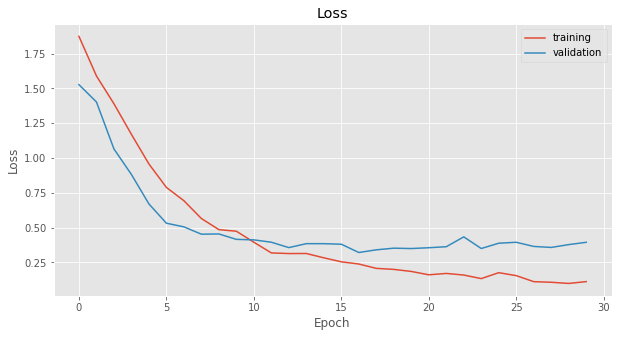

In [8]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


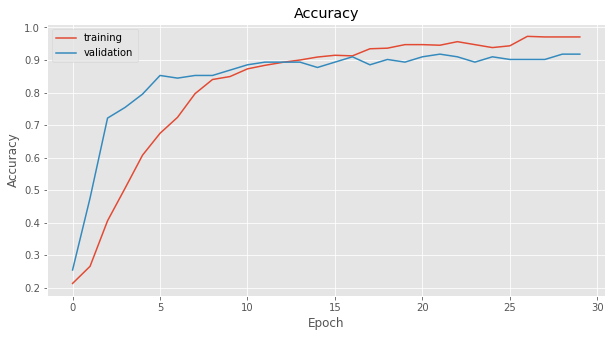

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


## Mengubah Model

In [10]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)


INFO:tensorflow:Assets written to: saved_model/assets


In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


In [12]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


13000200